In [66]:
##How to perform active machine learning

# Normal libraries

from pandas import read_csv
import pandas as pd
import numpy as np
import datetime

# Library to build a model using keras that is build on tensorflow
# (a library on how to handle tensor and their function)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Library to build generic models

from scipy.optimize import curve_fit


# Libraries about the learning process of the actual AI
from keras.callbacks import ModelCheckpoint

# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Useful libraries
from matplotlib import pyplot as plt
import math

In [67]:
Sensors = pd.read_csv("../../../Downloads/appa2_timeline.csv", sep=",")
Sensors.set_index("channel", inplace=True)
Sensors = Sensors.applymap(lambda x: x.replace("*", ""))

df = read_csv("../../DataSet_FBK/ViaBolz.csv", sep=",", parse_dates=["ts"])
df.set_index("ts", inplace=True)

change = {}
for i in range(1, 9):
    change[f"S{str(i)}_R1"] = f"T{str(i)}"
    change[f"S{str(i)}_R2"] = f"R{str(i)}"
    change[f"S{str(i)}_Voltage"] = f"V{str(i)}"
df = df.rename(columns=change)


Test = {}
maxim = len(Sensors.columns)
for i, col in enumerate(Sensors.columns):
    materials = []
    if i == maxim - 1:
        for j, material in enumerate(Sensors[col]):
            f = materials.count(material) + 1
            materials.append(material)
            if list(Test.keys()).count(material + str(f)) == 1:
                Test[material + str(f)] = pd.concat(
                    [
                        Test[material + str(f)],
                        df[col:][
                            ["R" + str(j + 1), "T" + str(j + 1), "V" + str(j + 1)]
                        ].rename(
                            columns={
                                "R" + str(j + 1): "R",
                                "T" + str(j + 1): "HT",
                                "V" + str(j + 1): "V",
                            }
                        ),
                    ]
                )
            else:
                Test[material + str(f)] = df[col:][
                    ["R" + str(j + 1), "T" + str(j + 1), "V" + str(j + 1)]
                ].rename(
                    columns={
                        "R" + str(j + 1): "R",
                        "T" + str(j + 1): "HT",
                        "V" + str(j + 1): "V",
                    }
                )
    else:
        for j, material in enumerate(Sensors[col]):
            f = materials.count(material) + 1
            materials.append(material)
            if list(Test.keys()).count(material + str(f)) == 1:
                Test[material + str(f)] = pd.concat(
                    [
                        Test[material + str(f)],
                        df[col : Sensors.columns[i + 1]][
                            ["R" + str(j + 1), "T" + str(j + 1), "V" + str(j + 1)]
                        ].rename(
                            columns={
                                "R" + str(j + 1): "R",
                                "T" + str(j + 1): "HT",
                                "V" + str(j + 1): "V",
                            }
                        ),
                    ]
                )
            else:
                Test[material + str(f)] = df[col : Sensors.columns[i + 1]][
                    ["R" + str(j + 1), "T" + str(j + 1), "V" + str(j + 1)]
                ].rename(
                    columns={
                        "R" + str(j + 1): "R",
                        "T" + str(j + 1): "HT",
                        "V" + str(j + 1): "V",
                    }
                )

df8 = Test["LaFeO31"]

df_appa = read_csv("../../DataSet_APPA/APPA2.csv")
df_appa
df_appa.Time = pd.to_datetime(df_appa.Time)
timezone_offset = datetime.timedelta(hours=2)
timezone = datetime.timezone(timezone_offset)

df_appa.Time = df_appa.Time.apply(lambda x: x.replace(tzinfo=timezone))
df_appa.rename(columns={"Time": "ts"}, inplace=True)

In [88]:
df8 = df8.resample("1H").mean()
df_tot = df8.reset_index().merge(df_appa)
df_tot.set_index("ts", inplace=True)
df_tot = df_tot.sort_index().dropna()
df_tot = df_tot.dropna()

In [89]:
df_tot

,R,HT,V,model 1,PM10,Ossido di Carbonio,Biossido di Azoto
ts,,,,,,,
2021-01-13 10:00:00+00:00,3.293993e+07,77.171739,2.153696,56.094226,53.0,0.8,67.0
2021-01-13 11:00:00+00:00,2.648063e+05,90.883051,3.234746,40.457878,48.0,0.7,68.0
2021-01-13 12:00:00+00:00,2.617744e+05,90.857627,3.234746,40.456427,43.0,0.7,71.0
2021-01-13 13:00:00+00:00,2.601968e+05,90.866102,3.233898,40.455672,46.0,0.7,76.0
2021-01-13 14:00:00+00:00,2.600834e+05,90.801695,3.234068,40.455618,66.0,1.0,107.0
...,...,...,...,...,...,...,...
2023-06-26 05:00:00+00:00,2.850602e+06,112.324138,3.363276,41.695284,25.0,0.3,25.0
2023-06-26 06:00:00+00:00,3.045518e+06,112.315254,3.362712,41.788559,25.0,0.3,27.0
2023-06-26 07:00:00+00:00,2.443874e+06,112.268333,3.362167,41.500648,20.0,0.3,14.0


In [70]:
print(df_tot.sort_index().loc["2021-01-01":"2021-02-1"]["PM10"].values)

['53.0' '48.0' '43.0' '46.0' '66.0' '95.0' '100.0' '93.0' '104.0' '102.0'
 '87.0' '68.0' '64.0' '59.0' '43.0' '42.0' '40.0' '39.0' '35.0' '32.0'
 '46.0' '51.0' '54.0' '49.0' '41.0' '27.0' '17.0' '12.0' '9.0' '7.0' '9.0'
 '11.0' '16.0' '20.0' '32.0' '32.0' '29.0' '28.0' '18.0' '21.0' '23.0'
 '23.0' '23.0' '25.0' '25.0' '20.0' '16.0' '16.0' '17.0' '17.0' '17.0'
 '17.0' '29.0' '43.0' '50.0' '79.0' '61.0' '66.0' '72.0' '67.0' '55.0'
 '35.0' '34.0' '30.0' '25.0' '24.0' '21.0' '17.0' '17.0' '27.0' '32.0'
 '26.0' '19.0' '18.0' '17.0' '30.0' '21.0' '47.0' '62.0' '75.0' '108.0'
 '103.0' '73.0' '68.0' '54.0' '35.0' '30.0' '24.0' '22.0' '20.0' '22.0'
 '22.0' '25.0' '26.0' '30.0' '34.0' '41.0' '33.0' '37.0' '31.0' '33.0'
 '53.0' '84.0' '101.0' '105.0' '92.0' '85.0' '75.0' '65.0' '54.0' '49.0'
 '44.0' '35.0' '33.0' '33.0' '40.0' '47.0' '49.0' '51.0' '67.0' '54.0'
 '46.0' '50.0' '52.0' '74.0' '98.0' '119.0' '120.0' '128.0' '131.0' '84.0'
 '63.0' '52.0' '34.0' '33.0' '27.0' '18.0' '20.0' '18.0' '29.0

In [96]:
##Example of curve fit


##Define a model
def f_model(x, a, b, c, d, e):
    Sig, T, RH = x
    return a * Sig**b + d * T + e + c


##df8 is an example of a dataframe, indexed with data and with columns name not really informative

##You are training here from a start to end the slicing of a database
(
    popt,
    pcov,
) = curve_fit(  # popt are the optimal values, pcov is the covariance matrix of the optimized values.
    f=f_model,  # model function
    xdata=(
        df_tot.sort_index().loc["2021-01-01":"2021-04-1"]["V"].values,
        df_tot.sort_index().loc["2021-01-01":"2021-04-1"]["R"].values,
        df_tot.sort_index().loc["2021-01-01":"2021-04-1"]["HT"].values,
    ),  # x data
    ydata=df_tot.sort_index().loc["2021-01-01":"2021-04-1"]["PM10"].values,  # y data
    p0=(4, 1, 1, 1, 1),  # initial value of the parameters
    maxfev=10000,  # Number of times in which you repeat the training, close to epochs
)
a_opt, b_opt, c_opt, d_opt, e_opt = popt
df_tot["model 1"] = f_model(
    (df_tot["V"].values, df_tot["R"].values, df_tot["HT"].values),
    a_opt,
    b_opt,
    c_opt,
    d_opt,
    e_opt,
)  # Here you are predicting the value of your complete samples

c:\Users\lucag\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\lucag\AppData\Local\Temp\ipykernel_15568\4092839714.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot["model 1"] = f_model(


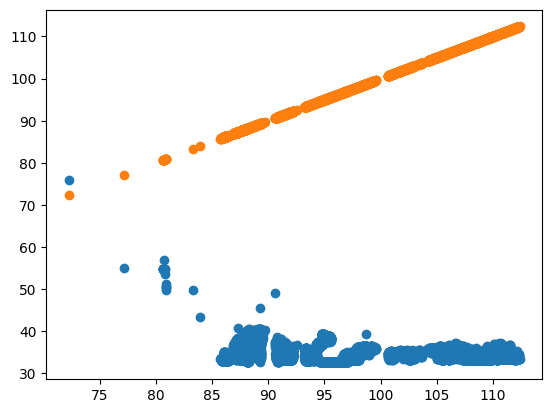

In [100]:
plt.scatter(df_tot["HT"], df_tot["model 1"])
plt.scatter(df_tot["HT"], df_tot["HT"])

In [108]:
df_tot

,R,HT,V,model 1,PM10,Ossido di Carbonio,Biossido di Azoto
ts,,,,,,,
2021-01-13 10:00:00+00:00,3.293993e+07,77.171739,2.153696,55.006531,53.0,0.8,67.0
2021-01-13 11:00:00+00:00,2.648063e+05,90.883051,3.234746,32.697212,48.0,0.7,68.0
2021-01-13 12:00:00+00:00,2.617744e+05,90.857627,3.234746,32.695142,43.0,0.7,71.0
2021-01-13 13:00:00+00:00,2.601968e+05,90.866102,3.233898,32.694065,46.0,0.7,76.0
2021-01-13 14:00:00+00:00,2.600834e+05,90.801695,3.234068,32.693987,66.0,1.0,107.0
...,...,...,...,...,...,...,...
2023-06-26 05:00:00+00:00,2.850602e+06,112.324138,3.363276,34.462694,25.0,0.3,25.0
2023-06-26 06:00:00+00:00,3.045518e+06,112.315254,3.362712,34.595775,25.0,0.3,27.0
2023-06-26 07:00:00+00:00,2.443874e+06,112.268333,3.362167,34.184995,20.0,0.3,14.0


In [129]:
##Example of Scaler, matrices or something like these

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

##Place whatever dataframe you want
X = df_tot.drop(["PM10","Ossido di Carbonio","Biossido di Azoto"], axis=1)

y = df_tot["Biossido di Azoto"].copy()

try :
    INPUT_DIM = len(X.columns)
    OUTPUT_DIM = len(y.columns)
except:
    INPUT_DIM = len(X.columns)
    OUTPUT_DIM = 1

In [130]:
# Split training and test, remember that you may want to not shuffle data while dividing them
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
# You perform a standard scaler (or minmax scaler) to make the data more usable by the machine learning
# model
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler()
scaler.fit(y_train.values.reshape(-1,1))

y_train_s = scaler.transform(y_train.values.reshape(-1,1))
y_test_s = scaler.transform(y_test.values.reshape(-1,1))

In [131]:
a2 = "mean_squared_error"
# define the model
# Experiment with deeper and wider networks
model = Sequential()
# By Sequential it means that the layers are connected one after the one before so that you have
# a defined flow of information


# Input layer, Dense layer meaning that the layer is connected to all the neurons to the layer before
# kernel_initializer is the how the starting values of the parameters of your neural network (NN)
# input_dim is the number of features of the dataset that you are feeding to your NN
# activation function is how you introduce non linearity in your model.

model.add(
    Dense(64, kernel_initializer="normal", input_dim=INPUT_DIM, activation="selu")
)

# Hidden layers:
# Dropout layer is just a layer where you drops, for example the 20% of the links between the two layers
# that it is placed between
model.add(Dropout(0.2))

model.add(Dense(128, kernel_initializer="normal", activation="selu"))
model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer="normal", activation="selu"))
model.add(Dropout(0.2))

model.add(Dense(16, kernel_initializer="normal", activation="selu"))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(OUTPUT_DIM, kernel_initializer="normal", activation="linear"))

# with add you can add a new layer, with pop you remove the last layer you have placed there


# You are compiling your model, so from now on you can't change its structure. Here you specify its loss function,
# the function that you want to minimize, the optimizer that is how you want to optimize the parameters,
# the metrics that is another value that you can use to measure your model but you won't use it to optimize
# the model
model.compile(loss=a2, optimizer="adam", metrics=[a2])
# You are showing how your NN is formed
model.summary()

##Here you are defining something that is not necessary. You are defining condition by which you are saving
# definite models. For example in that case you are specifing where do you want to place them, you are searching
# the model where the value of the loss function over the validation set (data not seen by the model during
# the training) is minimum. The weight of the "best model" by that value is saved there.
checkpoint_name = "./tmp/checkpoint"
checkpoint = ModelCheckpoint(
    checkpoint_name, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
callbacks_list = [checkpoint]
# In the history you collect the important information that happens during the fit, value of loss function,
# metrics and so on in one variable.
# During the fit  the parameters of the NN are updated. You are specifing the training data, X and y, and either
# you give the fit function the validation data or you give them a percentage as the validation_split, in this case 20%
# after that you are specifing the number of epochs, meaning how many time the model has seen the same data,
# and then the callbacks that you want to use. Notice that you can have more than one callback.
# There are more parameters that you can implement, so take a look at them
history = model.fit(
    X_train_scaled, y_train_s, validation_split=0.2, epochs=300, callbacks=[checkpoint]
)
# After performing the training you are uploading the best model that you have saved in the callback, updating
# the value of your parameters
model.load_weights(checkpoint_name)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                320       
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 16)               

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 2s 3ms/step - loss: 0.8909 - mean_squared_error: 0.8909 - val_loss: 0.9059 - val_mean_squared_error: 0.9059
Epoch 2/300
321/349 [==========================>...] - ETA: 0s - loss: 0.8771 - mean_squared_error: 0.8771
Epoch 2: val_loss improved from 0.90589 to 0.89220, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8752 - mean_squared_error: 0.8752 - val_loss: 0.8922 - val_mean_squared_error: 0.8922
Epoch 3/300
322/349 [==========================>...] - ETA: 0s - loss: 0.8760 - mean_squared_error: 0.8760
Epoch 3: val_loss improved from 0.89220 to 0.88104, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8677 - mean_squared_error: 0.8677 - val_loss: 0.8810 - val_mean_squared_error: 0.8810
Epoch 4/300
326/349 [===========================>..] - ETA: 0s - loss: 0.8591 - mean_squared_error: 0.8591
Epoch 4: val_loss improved from 0.88104 to 0.87744, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8571 - mean_squared_error: 0.8571 - val_loss: 0.8774 - val_mean_squared_error: 0.8774
Epoch 5/300
329/349 [===========================>..] - ETA: 0s - loss: 0.8580 - mean_squared_error: 0.8580
Epoch 5: val_loss improved from 0.87744 to 0.86032, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8567 - mean_squared_error: 0.8567 - val_loss: 0.8603 - val_mean_squared_error: 0.8603
Epoch 6/300
331/349 [===========================>..] - ETA: 0s - loss: 0.8421 - mean_squared_error: 0.8421
Epoch 6: val_loss improved from 0.86032 to 0.83846, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8386 - mean_squared_error: 0.8386 - val_loss: 0.8385 - val_mean_squared_error: 0.8385
Epoch 7/300
321/349 [==========================>...] - ETA: 0s - loss: 0.8206 - mean_squared_error: 0.8206
Epoch 7: val_loss improved from 0.83846 to 0.80925, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.8179 - mean_squared_error: 0.8179 - val_loss: 0.8093 - val_mean_squared_error: 0.8093
Epoch 8/300
332/349 [===========================>..] - ETA: 0s - loss: 0.7963 - mean_squared_error: 0.7963
Epoch 8: val_loss improved from 0.80925 to 0.76688, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7939 - mean_squared_error: 0.7939 - val_loss: 0.7669 - val_mean_squared_error: 0.7669
Epoch 9/300
316/349 [==========================>...] - ETA: 0s - loss: 0.7752 - mean_squared_error: 0.7752
Epoch 9: val_loss improved from 0.76688 to 0.76086, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7712 - mean_squared_error: 0.7712 - val_loss: 0.7609 - val_mean_squared_error: 0.7609
Epoch 10/300
326/349 [===========================>..] - ETA: 0s - loss: 0.7544 - mean_squared_error: 0.7544
Epoch 10: val_loss improved from 0.76086 to 0.72563, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7553 - mean_squared_error: 0.7553 - val_loss: 0.7256 - val_mean_squared_error: 0.7256
Epoch 11/300
315/349 [==========================>...] - ETA: 0s - loss: 0.7521 - mean_squared_error: 0.7521
Epoch 11: val_loss improved from 0.72563 to 0.72429, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.7504 - mean_squared_error: 0.7504 - val_loss: 0.7243 - val_mean_squared_error: 0.7243
Epoch 12/300
323/349 [==========================>...] - ETA: 0s - loss: 0.7472 - mean_squared_error: 0.7472
Epoch 12: val_loss improved from 0.72429 to 0.70542, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7430 - mean_squared_error: 0.7430 - val_loss: 0.7054 - val_mean_squared_error: 0.7054
Epoch 13/300
318/349 [==========================>...] - ETA: 0s - loss: 0.7358 - mean_squared_error: 0.7358
Epoch 13: val_loss did not improve from 0.70542
349/349 [==============================] - 0s 1ms/step - loss: 0.7348 - mean_squared_error: 0.7348 - val_loss: 0.7181 - val_mean_squared_error: 0.7181
Epoch 14/300
332/349 [===========================>..] - ETA: 0s - loss: 0.7281 - mean_squared_error: 0.7281
Epoch 14: val_loss improved from 0.70542 to 0.69326, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7317 - mean_squared_error: 0.7317 - val_loss: 0.6933 - val_mean_squared_error: 0.6933
Epoch 15/300
328/349 [===========================>..] - ETA: 0s - loss: 0.7264 - mean_squared_error: 0.7264
Epoch 15: val_loss did not improve from 0.69326
349/349 [==============================] - 0s 1ms/step - loss: 0.7231 - mean_squared_error: 0.7231 - val_loss: 0.6989 - val_mean_squared_error: 0.6989
Epoch 16/300
330/349 [===========================>..] - ETA: 0s - loss: 0.7169 - mean_squared_error: 0.7169
Epoch 16: val_loss improved from 0.69326 to 0.67154, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.7174 - mean_squared_error: 0.7174 - val_loss: 0.6715 - val_mean_squared_error: 0.6715
Epoch 17/300
322/349 [==========================>...] - ETA: 0s - loss: 0.7021 - mean_squared_error: 0.7021
Epoch 17: val_loss did not improve from 0.67154
349/349 [==============================] - 0s 1ms/step - loss: 0.7035 - mean_squared_error: 0.7035 - val_loss: 0.6966 - val_mean_squared_error: 0.6966
Epoch 18/300
337/349 [===========================>..] - ETA: 0s - loss: 0.6983 - mean_squared_error: 0.6983
Epoch 18: val_loss did not improve from 0.67154
349/349 [==============================] - 0s 1ms/step - loss: 0.6960 - mean_squared_error: 0.6960 - val_loss: 0.6829 - val_mean_squared_error: 0.6829
Epoch 19/300
322/349 [==========================>...] - ETA: 0s - loss: 0.6858 - mean_squared_error: 0.6858
Epoch 19: val_loss improved from 0.67154 to 0.66461, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6851 - mean_squared_error: 0.6851 - val_loss: 0.6646 - val_mean_squared_error: 0.6646
Epoch 20/300
329/349 [===========================>..] - ETA: 0s - loss: 0.6875 - mean_squared_error: 0.6875
Epoch 20: val_loss did not improve from 0.66461
349/349 [==============================] - 0s 1ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - val_loss: 0.6862 - val_mean_squared_error: 0.6862
Epoch 21/300
318/349 [==========================>...] - ETA: 0s - loss: 0.6782 - mean_squared_error: 0.6782
Epoch 21: val_loss improved from 0.66461 to 0.66136, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6809 - mean_squared_error: 0.6809 - val_loss: 0.6614 - val_mean_squared_error: 0.6614
Epoch 22/300
347/349 [============================>.] - ETA: 0s - loss: 0.6812 - mean_squared_error: 0.6812
Epoch 22: val_loss improved from 0.66136 to 0.65332, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6802 - mean_squared_error: 0.6802 - val_loss: 0.6533 - val_mean_squared_error: 0.6533
Epoch 23/300
321/349 [==========================>...] - ETA: 0s - loss: 0.6856 - mean_squared_error: 0.6856
Epoch 23: val_loss did not improve from 0.65332
349/349 [==============================] - 0s 1ms/step - loss: 0.6852 - mean_squared_error: 0.6852 - val_loss: 0.6594 - val_mean_squared_error: 0.6594
Epoch 24/300
330/349 [===========================>..] - ETA: 0s - loss: 0.6714 - mean_squared_error: 0.6714
Epoch 24: val_loss did not improve from 0.65332
349/349 [==============================] - 0s 1ms/step - loss: 0.6721 - mean_squared_error: 0.6721 - val_loss: 0.6553 - val_mean_squared_error: 0.6553
Epoch 25/300
329/349 [===========================>..] - ETA: 0s - loss: 0.6733 - mean_squared_error: 0.6733
Epoch 25: val_loss improved from 0.65332 to 0.64360, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6726 - mean_squared_error: 0.6726 - val_loss: 0.6436 - val_mean_squared_error: 0.6436
Epoch 26/300
333/349 [===========================>..] - ETA: 0s - loss: 0.6735 - mean_squared_error: 0.6735
Epoch 26: val_loss did not improve from 0.64360
349/349 [==============================] - 0s 1ms/step - loss: 0.6727 - mean_squared_error: 0.6727 - val_loss: 0.6733 - val_mean_squared_error: 0.6733
Epoch 27/300
330/349 [===========================>..] - ETA: 0s - loss: 0.6739 - mean_squared_error: 0.6739
Epoch 27: val_loss did not improve from 0.64360
349/349 [==============================] - 0s 1ms/step - loss: 0.6733 - mean_squared_error: 0.6733 - val_loss: 0.6620 - val_mean_squared_error: 0.6620
Epoch 28/300
333/349 [===========================>..] - ETA: 0s - loss: 0.6664 - mean_squared_error: 0.6664
Epoch 28: val_loss did not improve from 0.64360
349/349 [==============================] - 0s 1ms/step - loss: 0.6649 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6580 - mean_squared_error: 0.6580 - val_loss: 0.6390 - val_mean_squared_error: 0.6390
Epoch 33/300
342/349 [============================>.] - ETA: 0s - loss: 0.6651 - mean_squared_error: 0.6651
Epoch 33: val_loss improved from 0.63896 to 0.62954, saving model to ./tmp\checkpoint


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6636 - mean_squared_error: 0.6636 - val_loss: 0.6295 - val_mean_squared_error: 0.6295
Epoch 34/300
327/349 [===========================>..] - ETA: 0s - loss: 0.6634 - mean_squared_error: 0.6634
Epoch 34: val_loss did not improve from 0.62954
349/349 [==============================] - 0s 1ms/step - loss: 0.6596 - mean_squared_error: 0.6596 - val_loss: 0.6393 - val_mean_squared_error: 0.6393
Epoch 35/300
345/349 [============================>.] - ETA: 0s - loss: 0.6628 - mean_squared_error: 0.6628
Epoch 35: val_loss did not improve from 0.62954
349/349 [==============================] - 0s 1ms/step - loss: 0.6629 - mean_squared_error: 0.6629 - val_loss: 0.6693 - val_mean_squared_error: 0.6693
Epoch 36/300
335/349 [===========================>..] - ETA: 0s - loss: 0.6598 - mean_squared_error: 0.6598
Epoch 36: val_loss did not improve from 0.62954
349/349 [==============================] - 0s 1ms/step - loss: 0.6599 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.6291 - val_mean_squared_error: 0.6291
Epoch 39/300
321/349 [==========================>...] - ETA: 0s - loss: 0.6573 - mean_squared_error: 0.6573
Epoch 39: val_loss did not improve from 0.62910
349/349 [==============================] - 0s 1ms/step - loss: 0.6579 - mean_squared_error: 0.6579 - val_loss: 0.6438 - val_mean_squared_error: 0.6438
Epoch 40/300
344/349 [============================>.] - ETA: 0s - loss: 0.6570 - mean_squared_error: 0.6570
Epoch 40: val_loss did not improve from 0.62910
349/349 [==============================] - 0s 1ms/step - loss: 0.6574 - mean_squared_error: 0.6574 - val_loss: 0.6387 - val_mean_squared_error: 0.6387
Epoch 41/300
338/349 [============================>.] - ETA: 0s - loss: 0.6610 - mean_squared_error: 0.6610
Epoch 41: val_loss did not improve from 0.62910
349/349 [==============================] - 0s 1ms/step - loss: 0.6612 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6466 - mean_squared_error: 0.6466 - val_loss: 0.6257 - val_mean_squared_error: 0.6257
Epoch 50/300
319/349 [==========================>...] - ETA: 0s - loss: 0.6545 - mean_squared_error: 0.6545
Epoch 50: val_loss did not improve from 0.62565
349/349 [==============================] - 0s 1ms/step - loss: 0.6493 - mean_squared_error: 0.6493 - val_loss: 0.6299 - val_mean_squared_error: 0.6299
Epoch 51/300
336/349 [===========================>..] - ETA: 0s - loss: 0.6484 - mean_squared_error: 0.6484
Epoch 51: val_loss did not improve from 0.62565
349/349 [==============================] - 0s 1ms/step - loss: 0.6483 - mean_squared_error: 0.6483 - val_loss: 0.6362 - val_mean_squared_error: 0.6362
Epoch 52/300
324/349 [==========================>...] - ETA: 0s - loss: 0.6587 - mean_squared_error: 0.6587
Epoch 52: val_loss did not improve from 0.62565
349/349 [==============================] - 0s 1ms/step - loss: 0.6561 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6442 - mean_squared_error: 0.6442 - val_loss: 0.6255 - val_mean_squared_error: 0.6255
Epoch 70/300
333/349 [===========================>..] - ETA: 0s - loss: 0.6490 - mean_squared_error: 0.6490
Epoch 70: val_loss did not improve from 0.62548
349/349 [==============================] - 0s 1ms/step - loss: 0.6478 - mean_squared_error: 0.6478 - val_loss: 0.6369 - val_mean_squared_error: 0.6369
Epoch 71/300
338/349 [============================>.] - ETA: 0s - loss: 0.6372 - mean_squared_error: 0.6372
Epoch 71: val_loss did not improve from 0.62548
349/349 [==============================] - 0s 1ms/step - loss: 0.6361 - mean_squared_error: 0.6361 - val_loss: 0.6352 - val_mean_squared_error: 0.6352
Epoch 72/300
347/349 [============================>.] - ETA: 0s - loss: 0.6436 - mean_squared_error: 0.6436
Epoch 72: val_loss did not improve from 0.62548
349/349 [==============================] - 0s 1ms/step - loss: 0.6431 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6424 - mean_squared_error: 0.6424 - val_loss: 0.6223 - val_mean_squared_error: 0.6223
Epoch 78/300
334/349 [===========================>..] - ETA: 0s - loss: 0.6442 - mean_squared_error: 0.6442
Epoch 78: val_loss did not improve from 0.62230
349/349 [==============================] - 0s 1ms/step - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 0.6500 - val_mean_squared_error: 0.6500
Epoch 79/300
339/349 [============================>.] - ETA: 0s - loss: 0.6448 - mean_squared_error: 0.6448
Epoch 79: val_loss did not improve from 0.62230
349/349 [==============================] - 0s 1ms/step - loss: 0.6439 - mean_squared_error: 0.6439 - val_loss: 0.6305 - val_mean_squared_error: 0.6305
Epoch 80/300
337/349 [===========================>..] - ETA: 0s - loss: 0.6434 - mean_squared_error: 0.6434
Epoch 80: val_loss did not improve from 0.62230
349/349 [==============================] - 0s 1ms/step - loss: 0.6424 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6449 - mean_squared_error: 0.6449 - val_loss: 0.6205 - val_mean_squared_error: 0.6205
Epoch 82/300
324/349 [==========================>...] - ETA: 0s - loss: 0.6356 - mean_squared_error: 0.6356
Epoch 82: val_loss did not improve from 0.62050
349/349 [==============================] - 0s 1ms/step - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6314 - val_mean_squared_error: 0.6314
Epoch 83/300
317/349 [==========================>...] - ETA: 0s - loss: 0.6516 - mean_squared_error: 0.6516
Epoch 83: val_loss did not improve from 0.62050
349/349 [==============================] - 0s 1ms/step - loss: 0.6472 - mean_squared_error: 0.6472 - val_loss: 0.6372 - val_mean_squared_error: 0.6372
Epoch 84/300
327/349 [===========================>..] - ETA: 0s - loss: 0.6404 - mean_squared_error: 0.6404
Epoch 84: val_loss did not improve from 0.62050
349/349 [==============================] - 0s 1ms/step - loss: 0.6426 - mean_sq

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6194 - val_mean_squared_error: 0.6194
Epoch 101/300
326/349 [===========================>..] - ETA: 0s - loss: 0.6335 - mean_squared_error: 0.6335
Epoch 101: val_loss did not improve from 0.61939
349/349 [==============================] - 1s 1ms/step - loss: 0.6338 - mean_squared_error: 0.6338 - val_loss: 0.6335 - val_mean_squared_error: 0.6335
Epoch 102/300
322/349 [==========================>...] - ETA: 0s - loss: 0.6392 - mean_squared_error: 0.6392
Epoch 102: val_loss did not improve from 0.61939
349/349 [==============================] - 1s 1ms/step - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6276 - val_mean_squared_error: 0.6276
Epoch 103/300
345/349 [============================>.] - ETA: 0s - loss: 0.6386 - mean_squared_error: 0.6386
Epoch 103: val_loss did not improve from 0.61939
349/349 [==============================] - 1s 2ms/step - loss: 0.6374 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6418 - mean_squared_error: 0.6418 - val_loss: 0.6183 - val_mean_squared_error: 0.6183
Epoch 109/300
337/349 [===========================>..] - ETA: 0s - loss: 0.6377 - mean_squared_error: 0.6377
Epoch 109: val_loss did not improve from 0.61834
349/349 [==============================] - 1s 2ms/step - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6197 - val_mean_squared_error: 0.6197
Epoch 110/300
345/349 [============================>.] - ETA: 0s - loss: 0.6448 - mean_squared_error: 0.6448
Epoch 110: val_loss did not improve from 0.61834
349/349 [==============================] - 0s 1ms/step - loss: 0.6439 - mean_squared_error: 0.6439 - val_loss: 0.6280 - val_mean_squared_error: 0.6280
Epoch 111/300
345/349 [============================>.] - ETA: 0s - loss: 0.6412 - mean_squared_error: 0.6412
Epoch 111: val_loss did not improve from 0.61834
349/349 [==============================] - 0s 1ms/step - loss: 0.6416 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6346 - mean_squared_error: 0.6346 - val_loss: 0.6178 - val_mean_squared_error: 0.6178
Epoch 115/300
313/349 [=========================>....] - ETA: 0s - loss: 0.6363 - mean_squared_error: 0.6363
Epoch 115: val_loss did not improve from 0.61778
349/349 [==============================] - 1s 2ms/step - loss: 0.6413 - mean_squared_error: 0.6413 - val_loss: 0.6577 - val_mean_squared_error: 0.6577
Epoch 116/300
322/349 [==========================>...] - ETA: 0s - loss: 0.6528 - mean_squared_error: 0.6528
Epoch 116: val_loss did not improve from 0.61778
349/349 [==============================] - 1s 2ms/step - loss: 0.6463 - mean_squared_error: 0.6463 - val_loss: 0.6261 - val_mean_squared_error: 0.6261
Epoch 117/300
334/349 [===========================>..] - ETA: 0s - loss: 0.6445 - mean_squared_error: 0.6445
Epoch 117: val_loss did not improve from 0.61778
349/349 [==============================] - 1s 1ms/step - loss: 0.6426 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6410 - mean_squared_error: 0.6410 - val_loss: 0.6142 - val_mean_squared_error: 0.6142
Epoch 120/300
338/349 [============================>.] - ETA: 0s - loss: 0.6405 - mean_squared_error: 0.6405
Epoch 120: val_loss did not improve from 0.61421
349/349 [==============================] - 1s 2ms/step - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6183 - val_mean_squared_error: 0.6183
Epoch 121/300
319/349 [==========================>...] - ETA: 0s - loss: 0.6423 - mean_squared_error: 0.6423
Epoch 121: val_loss did not improve from 0.61421
349/349 [==============================] - 1s 2ms/step - loss: 0.6383 - mean_squared_error: 0.6383 - val_loss: 0.6778 - val_mean_squared_error: 0.6778
Epoch 122/300
343/349 [============================>.] - ETA: 0s - loss: 0.6364 - mean_squared_error: 0.6364
Epoch 122: val_loss did not improve from 0.61421
349/349 [==============================] - 0s 1ms/step - loss: 0.6363 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6331 - mean_squared_error: 0.6331 - val_loss: 0.6126 - val_mean_squared_error: 0.6126
Epoch 133/300
313/349 [=========================>....] - ETA: 0s - loss: 0.6378 - mean_squared_error: 0.6378
Epoch 133: val_loss did not improve from 0.61259
349/349 [==============================] - 1s 2ms/step - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6183 - val_mean_squared_error: 0.6183
Epoch 134/300
346/349 [============================>.] - ETA: 0s - loss: 0.6410 - mean_squared_error: 0.6410
Epoch 134: val_loss did not improve from 0.61259
349/349 [==============================] - 1s 2ms/step - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 0.6188 - val_mean_squared_error: 0.6188
Epoch 135/300
330/349 [===========================>..] - ETA: 0s - loss: 0.6394 - mean_squared_error: 0.6394
Epoch 135: val_loss did not improve from 0.61259
349/349 [==============================] - 1s 1ms/step - loss: 0.6376 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6326 - mean_squared_error: 0.6326 - val_loss: 0.6109 - val_mean_squared_error: 0.6109
Epoch 146/300
334/349 [===========================>..] - ETA: 0s - loss: 0.6371 - mean_squared_error: 0.6371
Epoch 146: val_loss did not improve from 0.61091
349/349 [==============================] - 0s 1ms/step - loss: 0.6383 - mean_squared_error: 0.6383 - val_loss: 0.6243 - val_mean_squared_error: 0.6243
Epoch 147/300
320/349 [==========================>...] - ETA: 0s - loss: 0.6403 - mean_squared_error: 0.6403
Epoch 147: val_loss did not improve from 0.61091
349/349 [==============================] - 0s 1ms/step - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.6218 - val_mean_squared_error: 0.6218
Epoch 148/300
331/349 [===========================>..] - ETA: 0s - loss: 0.6341 - mean_squared_error: 0.6341
Epoch 148: val_loss did not improve from 0.61091
349/349 [==============================] - 1s 2ms/step - loss: 0.6372 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 3ms/step - loss: 0.6306 - mean_squared_error: 0.6306 - val_loss: 0.6107 - val_mean_squared_error: 0.6107
Epoch 177/300
320/349 [==========================>...] - ETA: 0s - loss: 0.6279 - mean_squared_error: 0.6279
Epoch 177: val_loss did not improve from 0.61073
349/349 [==============================] - 0s 1ms/step - loss: 0.6289 - mean_squared_error: 0.6289 - val_loss: 0.6234 - val_mean_squared_error: 0.6234
Epoch 178/300
317/349 [==========================>...] - ETA: 0s - loss: 0.6364 - mean_squared_error: 0.6364
Epoch 178: val_loss did not improve from 0.61073
349/349 [==============================] - 0s 1ms/step - loss: 0.6411 - mean_squared_error: 0.6411 - val_loss: 0.6157 - val_mean_squared_error: 0.6157
Epoch 179/300
342/349 [============================>.] - ETA: 0s - loss: 0.6329 - mean_squared_error: 0.6329
Epoch 179: val_loss did not improve from 0.61073
349/349 [==============================] - 0s 1ms/step - loss: 0.6337 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 1s 4ms/step - loss: 0.6278 - mean_squared_error: 0.6278 - val_loss: 0.6082 - val_mean_squared_error: 0.6082
Epoch 195/300
315/349 [==========================>...] - ETA: 0s - loss: 0.6273 - mean_squared_error: 0.6273
Epoch 195: val_loss did not improve from 0.60822
349/349 [==============================] - 0s 1ms/step - loss: 0.6269 - mean_squared_error: 0.6269 - val_loss: 0.6251 - val_mean_squared_error: 0.6251
Epoch 196/300
337/349 [===========================>..] - ETA: 0s - loss: 0.6270 - mean_squared_error: 0.6270
Epoch 196: val_loss did not improve from 0.60822
349/349 [==============================] - 1s 1ms/step - loss: 0.6268 - mean_squared_error: 0.6268 - val_loss: 0.6200 - val_mean_squared_error: 0.6200
Epoch 197/300
334/349 [===========================>..] - ETA: 0s - loss: 0.6307 - mean_squared_error: 0.6307
Epoch 197: val_loss did not improve from 0.60822
349/349 [==============================] - 1s 2ms/step - loss: 0.6282 - m

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


349/349 [==============================] - 2s 5ms/step - loss: 0.6326 - mean_squared_error: 0.6326 - val_loss: 0.6006 - val_mean_squared_error: 0.6006
Epoch 204/300
319/349 [==========================>...] - ETA: 0s - loss: 0.6328 - mean_squared_error: 0.6328
Epoch 204: val_loss did not improve from 0.60065
349/349 [==============================] - 1s 2ms/step - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.6114 - val_mean_squared_error: 0.6114
Epoch 205/300
339/349 [============================>.] - ETA: 0s - loss: 0.6259 - mean_squared_error: 0.6259
Epoch 205: val_loss did not improve from 0.60065
349/349 [==============================] - 1s 1ms/step - loss: 0.6269 - mean_squared_error: 0.6269 - val_loss: 0.6409 - val_mean_squared_error: 0.6409
Epoch 206/300
340/349 [============================>.] - ETA: 0s - loss: 0.6365 - mean_squared_error: 0.6365
Epoch 206: val_loss did not improve from 0.60065
349/349 [==============================] - 1s 2ms/step - loss: 0.6364 - m

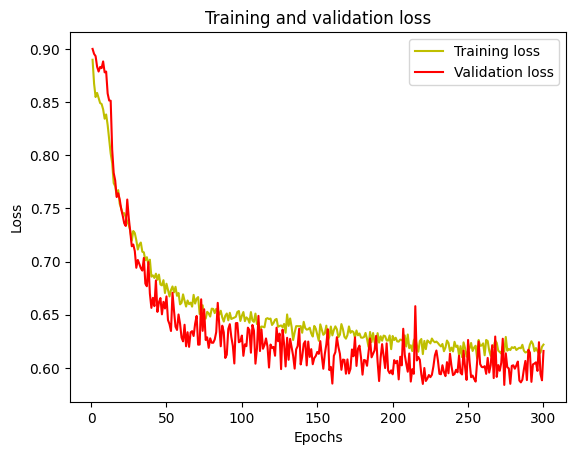

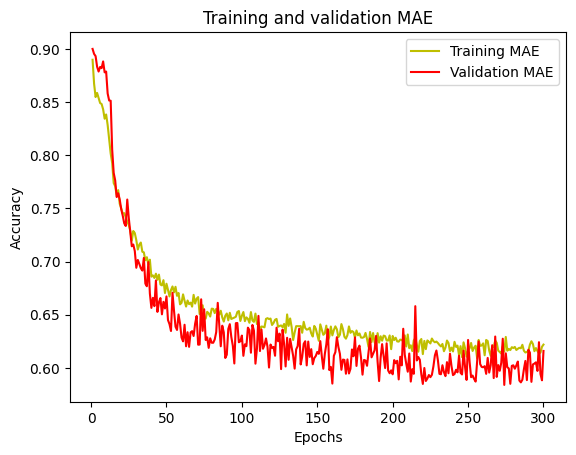

187/187 [==============================] - 0s 565us/step
Predicted values are:  [[21.408161]
 [37.08385 ]
 [22.988255]
 ...
 [20.16892 ]
 [56.66393 ]
 [15.669499]]
Real values are:  ts
2022-10-11 23:00:00+00:00    27.0
2023-02-28 21:00:00+00:00    40.0
2022-10-30 07:00:00+00:00    24.0
2022-10-01 19:00:00+00:00    17.0
2021-06-01 04:00:00+00:00    22.0
                             ... 
2021-04-12 03:00:00+00:00    11.0
2021-07-17 12:00:00+00:00     3.0
2021-04-15 22:00:00+00:00    14.0
2023-01-14 07:00:00+00:00    43.0
2021-07-17 02:00:00+00:00    10.0
Name: PM10, Length: 5983, dtype: float64


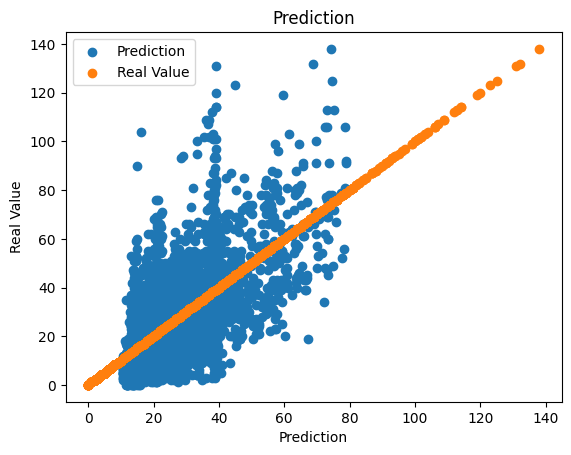

In [128]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


acc = history.history["mean_squared_error"]
val_acc = history.history["val_mean_squared_error"]
plt.plot(epochs, acc, "y", label="Training MAE")
plt.plot(epochs, val_acc, "r", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

############################################
# Predict on test data
predictions = model.predict(X_test_scaled)

predictions = scaler.inverse_transform(predictions)

y_test_ssaved = y_test_s
y_test_s = y_test
print("Predicted values are: ", predictions)
print("Real values are: ", y_test_s)

##############################################
# Plot and compare prediction and real value
t = np.arange(0, predictions.size, 1)
plt.scatter(predictions, y_test_s, label="Prediction")
plt.scatter(y_test_s, y_test_s, label="Real Value")
plt.title("Prediction")
plt.xlabel("Prediction")
plt.ylabel("Real Value")
plt.legend()
plt.show()

In [137]:
##Example of RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.metrics import r2_score

In [138]:
##Same thing you have done before, define an X and y from a dataset if you want to try.

xtrain, xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, test_size=0.20)
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler.fit(xtrain)

X_train = scaler.transform(xtrain)
X_test = scaler.transform(xtest)
scaler2.fit(ytrain.values.reshape(-1, 1))

y_train = scaler2.transform(ytrain.values.reshape(-1, 1))
y_test = scaler2.transform(ytest.values.reshape(-1, 1))

In [139]:
rfr = RandomForestRegressor()


# Here are some hyperparameter of your regressor, it's a bit better and easier to look up at what the difference
# parameter does. All of this hyperparameter can be optimized using the validation data.
RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion="mse",
    max_depth=10,
    max_features=3,
    max_leaf_nodes=None,
    max_samples=0.1,
    min_impurity_decrease=0.0,
    min_samples_leaf=0.01,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=None,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False,
)

RandomForestRegressor(criterion='mse', max_depth=10, max_features=3,
                      max_samples=0.1, min_samples_leaf=0.01)

In [140]:
# fit of the RandomForestRegressor

rfr.fit(X_train, y_train.reshape(-1, 1))
# evaluation of its performance by the R-squared

score = rfr.score(X_train, y_train.reshape(-1, 1))
print("R-squared:", score)

ypred = rfr.predict(X_test)
# evaluation of its performance by the mean_squared_error

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse * (1 / 2.0))

plt.scatter(ytest, ypred)
plt.scatter(ytest, ytest)

c:\Users\lucag\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: 0.92867360776298
MSE:  0.0077246897095910845
RMSE:  0.0038623448547955423
